In [ ]:
## Import required packages for data manipulation and visualization, and curve fitting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
try:
  from fitter import Fitter, get_common_distributions, get_distributions
except:
  !pip install fitter
  from fitter import Fitter
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
!pip install catBoost

In [ ]:
greeks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Alpha    617 non-null    object
 1   Beta     617 non-null    object
 2   Gamma    617 non-null    object
 3   Delta    617 non-null    object
 4   Epsilon  617 non-null    object
dtypes: object(5)
memory usage: 28.9+ KB


In [ ]:
from sklearn.preprocessing import LabelEncoder

def encode_class_as_label(df):

    le = LabelEncoder()
    df.Class = le.fit_transform(df.Class)

    return df

In [ ]:
def one_hot_encode_feature(df, col='EJ'):
    """
    Given dataframe df performs one hot encoding on categorical feature col
    """
    if df[col].isna().sum() != 0:
        df[col].fillna(value=df[col].mode, inplace=True)

    encoded_feature = pd.get_dummies(df[col], prefix=f'{col}')
    df.drop([col], axis=1, inplace=True)
    df = df.join(encoded_feature)

    if f'{col}_A' not in df.columns:
        df[f'{col}_A'] = 0

    if f'{col}_B' not in df.columns:
        df[f'{col}_B'] = 0

    return df

In [ ]:
def fit_and_sample(data, n_missing):
    """
    Fit a ditribution on the given data and return randomly picked samples/distribution mode
    based on the fitted distribution.
    """
    distribution_list = {
        'dweibull': scipy.stats.dweibull,
        'gengamma': scipy.stats.gengamma,
        'chi': scipy.stats.chi
    }

    if n_missing > 5:
        try:
            f = Fitter(data, distributions=distribution_list.keys())
            f.fit()

            # Find the best fitting distribution
            best_fit = list(f.get_best().keys())[0]

            # Generating values based on probability distribution
            high = data.max()
            low = data.min()
            x = np.linspace(low, high, num=len(data))

            dist = distribution_list[best_fit]
            samples = dist.rvs(*f.fitted_param[best_fit], size=n_missing)

            return samples


        except:
            distribution = np.histogram(data)
            mode = distribution[1][distribution[0].argmax()+1]

            return np.array([mode]*n_missing)


    else:

        distribution = np.histogram(data)
        mode = distribution[1][distribution[0].argmax()+1]

        return mode

In [ ]:
def impute_missing_values(df):
    """
    Imputes missing values in the given dataframe df based on a fitted probability distribution.
    """

    for col in df.columns:

        if df[col].isna().sum() == 0:

            # Pass if the feature column does not contain any missing values
            pass


        else:

            if 'Class' in df.columns:
                # Fit the feature column values on a list of distributions
                df_class_0 = df[df.Class == 0][col]
                df_class_1 = df[df.Class == 1][col]

                if df_class_0.isna().sum() != 0:
                    df.loc[(df[col].isna())&(df.Class == 0), col] = \
                        fit_and_sample(df[(df[col].notna())&(df.Class == 0)][col], df_class_0.isna().sum())

                if df_class_1.isna().sum() != 0:
                    df.loc[(df[col].isna())&(df.Class == 1), col] = \
                        fit_and_sample(df[(df[col].notna())&(df.Class == 1)][col], df_class_1.isna().sum())

            else:
                df.loc[(df[col].isna()), col] = fit_and_sample(df[(df[col].notna())][col], df[col].isna().sum())


    # Check if any missing values exist
    print(f"Number of missing values: {df.isna().sum().sum()}")


    return df

In [ ]:
def get_log_loss(y_true, prob_pred):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_0 = y_true
    y_1 = -1 * (y_true - 1)

    p_0 = np.log(prob_pred + 0.000001)
    p_1 = np.log(1 - prob_pred + 0.000001)


    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss

In [ ]:
def oversample_data(X, y, pass_func=False):

    if pass_func:
        return X, y

    else:
        oversample = SMOTE()

        df, y_oversampled = oversample.fit_resample(X, y)
        df['Class'] = y_oversampled

        df = df.sample(frac=1).reset_index(drop=True)


        return df.drop('Class', axis=1), df['Class']



def reduce_dimensions(df, num_components=30):

    pca = PCA(n_components=num_components)
    new_cols = [f'component_{i+1}' for i in range(num_components)]

    X = pca.fit_transform(df)

    return pd.DataFrame(X, columns=new_cols)

In [ ]:
def join_greeks(df, greeks, join_class):

    df = pd.merge(greeks[(greeks.Alpha == 'A')|(greeks.Alpha == join_class)]['Alpha'], df, \
                      left_index=True, right_index=True)

    df.drop(['Class'], axis=1, inplace=True)
    df.rename({'Alpha': 'Class'}, inplace=True, axis=1)
    df['Class'] = df.pop('Class')

    return df

# Pre-process and prepare for modeling

In [ ]:

## Reading the train and test data csv files from the data folder

try:
  train_data = pd.read_csv('./data/icr-identify-age-related-conditions/train.csv', index_col='Id')
  test_data = pd.read_csv('./data/icr-identify-age-related-conditions/test.csv', index_col='Id')
  greeks = pd.read_csv('./data/icr-identify-age-related-conditions/greeks.csv', index_col='Id')

except:
  from google.colab import drive
  drive.mount('/content/drive')
  train_data = pd.read_csv('/content/drive/MyDrive/Capstone/ICR - Identifying Age-Related Conditions/data/train.csv', index_col='Id')
  test_data = pd.read_csv('/content/drive/MyDrive/Capstone/ICR - Identifying Age-Related Conditions/data/test.csv', index_col='Id')
  greeks = pd.read_csv('/content/drive/MyDrive/Capstone/ICR - Identifying Age-Related Conditions/data/greeks.csv', index_col='Id')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data.drop('Class', axis=1), train_data['Class'], test_size=0.20, random_state=42)

In [ ]:
# One hot encode data
train_data = pd.concat([X_train, y_train], axis=1)

train_ohe = one_hot_encode_feature(train_data.copy())
test_ohe = one_hot_encode_feature(X_test.copy())


# Impute missing values
train_df = impute_missing_values(train_ohe.copy())
test_df = impute_missing_values(test_ohe.copy())


# Scale data between 0 and 1

for col in train_df.drop('Class', axis=1).columns:

    train_len = train_df.shape[0]
    scalar = MinMaxScaler(feature_range=(0,1))
    scaled_values = scalar.fit_transform(pd.concat([train_df.loc[:, [col]], test_df.loc[:, [col]]], axis=0))
    train_df[col] = scaled_values[:train_len, :]
    test_df[col] =  scaled_values[train_len:, :]


X_test = test_df.copy()

# Join greeks data
train_df_B = join_greeks(train_df, greeks, join_class='B')
train_df_D = join_greeks(train_df, greeks, join_class='D')
train_df_G = join_greeks(train_df, greeks, join_class='G')

train_df = pd.merge(greeks['Alpha'], train_df, \
                  left_index=True, right_index=True)

train_df.drop(['Class'], axis=1, inplace=True)
train_df.rename({'Alpha': 'Class'}, inplace=True, axis=1)
train_df['Class'] = train_df.pop('Class')



# Encode labels
train_df_B = encode_class_as_label(train_df_B)
train_df_D = encode_class_as_label(train_df_D)
train_df_G = encode_class_as_label(train_df_G)
train_df = encode_class_as_label(train_df.copy())



# Oversample data for minority class
X_train_B, y_train_B = oversample_data(train_df_B.drop('Class', axis=1), train_df_B['Class'])
X_train_D, y_train_D = oversample_data(train_df_D.drop('Class', axis=1), train_df_D['Class'])
X_train_G, y_train_G = oversample_data(train_df_G.drop('Class', axis=1), train_df_G['Class'])
X_train_4L, y_train_4L = oversample_data(train_df.drop('Class', axis=1), train_df['Class'])

Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]


Number of missing values: 0


Fitting 3 distributions: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]


Number of missing values: 0


In [ ]:
from catboost import CatBoostClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
from sklearn.metrics import recall_score, f1_score

def get_log_loss(y_true, class_0, class_1):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_1 = y_true
    y_0 = -1 * (y_true - 1)

    p_0 = np.log(class_0 + 0.000001)
    p_1 = np.log(class_1 + 0.000001)


    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss


In [ ]:
models = [SVC(probability=True), \
          GaussianNB(var_smoothing=0.2), \
          RandomForestClassifier(), \
          CatBoostClassifier(verbose=False), \
          LogisticRegression(**{'C': 8, 'max_iter': 300, 'penalty': 'l2'})]

In [ ]:
X_train = pd.concat([X_train_B, X_train_D, X_train_G], axis=0)
y_train = pd.concat([y_train_B, y_train_D, y_train_G], axis=0)

model = models[0]

model_B = model
model_B.fit(X_train_B.iloc[:800], y_train_B.iloc[:800])
predictions = model_B.predict_proba(X_test)
class_0_B = predictions[:, 0]
class_1_B = predictions[:, 1]


model_D = model
model_D.fit(X_train_D, y_train_D)
predictions = model_D.predict_proba(X_test)
class_0_D = predictions[:, 0]
class_1_D = predictions[:, 1]


model_G = model
model_G.fit(X_train_G, y_train_G)
predictions = model_G.predict_proba(X_test)
class_0_G = predictions[:, 0]
class_1_G = predictions[:, 1]



model_all = model
model_all.fit(X_train_4L, y_train_4L)
predictions = model_all.predict_proba(X_test)
class_0_single = predictions[:, 0]
class_1_all = predictions[:, 1]
class_2_all = predictions[:, 2]
class_3_all = predictions[:, 3]

# Calculate probability votes for class 0 and 1 - multi-model approach
class_0 = np.max((class_0_B, class_0_D, class_0_G), 0)
class_1 = np.max((class_1_B, class_1_D, class_1_G), 0)

class_0_multi = class_0
class_1_multi = class_1
class_1_single = np.max((class_1_all, class_2_all, class_3_all), 0)
labels_pred_multi = np.zeros_like(class_0_multi)
labels_pred_single = np.zeros_like(class_1_single)

labels_pred_multi[class_1_multi > class_0_multi] = 1
labels_pred_single[class_1_single > class_0_single] = 1

In [ ]:
print(get_log_loss(y_test, class_0_multi, class_1_multi))
print(get_log_loss(y_test, class_0_single, class_1_single))

0.17384121668990066
0.44654982014023914


In [ ]:
print(recall_score(y_test, labels_pred_multi))
print(recall_score(y_test, labels_pred_single))

0.43478260869565216
0.8260869565217391


In [ ]:
print(f1_score(y_test, labels_pred_multi))
print(f1_score(y_test, labels_pred_single))

0.6060606060606061
0.6031746031746033


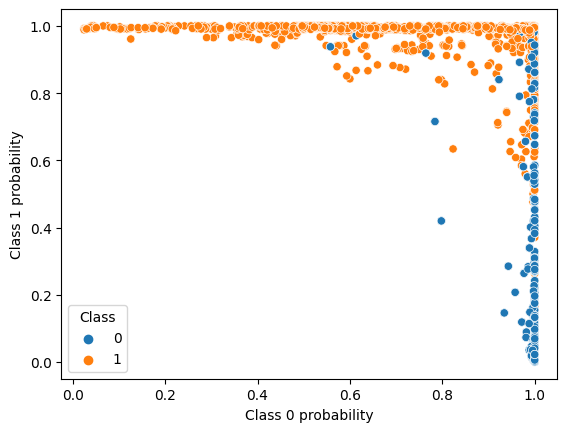

In [ ]:
# Visualize label correction with x-axis: class 0 & y_axis: class 1 probabilities
sns.scatterplot(x=class_0, y=class_1, hue=y_train)
# plt.plot([0,1], [1,0], 'black')
plt.xlabel('Class 0 probability')
plt.ylabel('Class 1 probability')
plt.show()

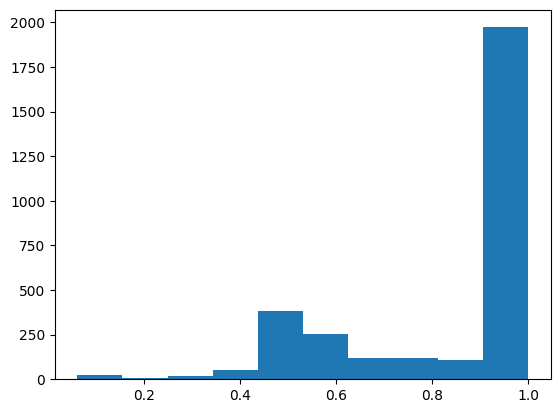

In [ ]:
plt.hist(class_0)
plt.show()

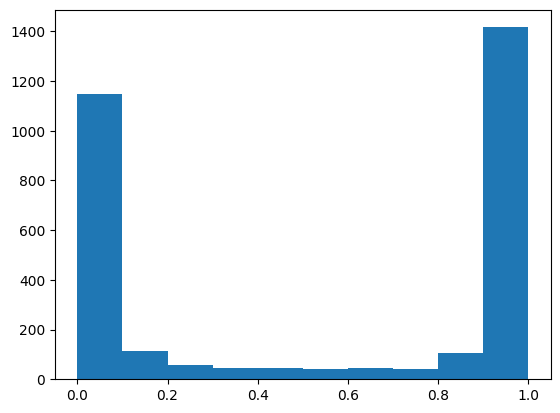

In [ ]:
plt.hist(class_1)
plt.show()

In [ ]:

get_log_loss_2(y_train, class_0, class_1)

0.03110642086218203

### Logistic Regression

In [ ]:
def get_log_loss(y_true, prob_pred):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_1 = y_true
    y_0 = -1 * (y_true - 1)

    p_0 = np.log(1-prob_pred + 0.000001)
    p_1 = np.log(prob_pred + 0.000001)


    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over
params = {'C': [1, 4,5,6,7,8], 'penalty': ['l2'], 'max_iter': [300, 400,500]}

# Create a grid search object
skf = StratifiedKFold(n_splits=5)
lr = LogisticRegression()

gs_LR = GridSearchCV(lr, param_grid=params, cv= skf, scoring = log_loss_score)

# Fit the grid search object to the training data
gs_LR.fit(X_train, y_train)

# Print the best parameters found by the grid search

print(gs_LR.best_params_)

pred = gs_LR.best_estimator_.predict(X_train)

log_loss_LR = get_log_loss(y_train, pred)
print(log_loss_LR)

{'C': 8, 'max_iter': 300, 'penalty': 'l2'}
1.144506015116687


Utilizing PCA

In [ ]:


log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over
params = {'C': [1, 4,5,6,7,8], 'penalty': ['l2'], 'max_iter': [300, 400,500]}

# Create a grid search object
skf = StratifiedKFold(n_splits=5)
lr = LogisticRegression()

gs_LR = GridSearchCV(lr, param_grid=params, cv= skf, scoring = log_loss_score)

X_train_pca = reduce_dimensions(X_train, num_components=30)

# Fit the grid search object to the training data
gs_LR.fit(X_train_pca, y_train)

# Print the best parameters found by the grid search

print(gs_LR.best_params_)

pred = gs_LR.best_estimator_.predict(X_train_pca)

log_loss_LR = get_log_loss(y_train, pred)
print(log_loss_LR)

{'C': 8, 'max_iter': 300, 'penalty': 'l2'}
1.5968803293918596


In [ ]:
def reduce_dimensions(df, num_components=30):

    pca = PCA(n_components=num_components)
    new_cols = [f'component_{i+1}' for i in range(num_components)]

    X = pca.fit_transform(df)

    return pd.DataFrame(X, columns=new_cols)

### KNN

In [ ]:
def get_log_loss_2(y_true, class_0, class_1):
    """
    Calculates log loss for two classes (0 & 1).
    Parameters:
        y_true: True labels array for the classes.
        prob_pred: Predicted probability values for the class.
    Returns:
        Log loss for the input.
    """

    N_0 = (y_true == 0).sum()
    N_1 = (y_true == 1).sum()

    y_1 = y_true
    y_0 = -1 * (y_true - 1)

    p_0 = np.log(class_0 + 0.000001)
    p_1 = np.log(class_1 + 0.000001)


    log_loss = ((-1/N_0)*(np.sum(y_0*p_0)) + (-1/N_1)*(np.sum(y_1*p_1)))/2

    return log_loss

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over
k = list(range(1, 25))

params = {'n_neighbors': k}


# Create a grid search object
skf = StratifiedKFold(n_splits=5)
KNN = KNeighborsClassifier()

gs_KNN = GridSearchCV(KNN, param_grid=params, cv= skf, scoring = log_loss_score)

# Fit the grid search object to the training data
gs_KNN.fit(X_train, y_train)

# Print the best parameters found by the grid search

print(gs_KNN.best_params_)

pred = gs_KNN.best_estimator_.predict_proba(X_train)

log_loss_KNN = get_log_loss_2(y_train, pred[:,0], pred[:,1])
print(log_loss_KNN)

{'n_neighbors': 1}
-9.999994999180668e-07


In [ ]:
pred[:,0]

array([1., 0., 1., ..., 1., 0., 1.])

### Naive Bayes

#### Naive Bayes - ComplementNB

In [ ]:
from sklearn.naive_bayes import ComplementNB

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
          'fit_prior': [True, False],
          'norm': [True, False]
         }


# Create a grid search object
skf = StratifiedKFold(n_splits=5)
CNB = ComplementNB()

gs_CNB = GridSearchCV(CNB, param_grid=params, cv= skf, scoring = log_loss_score)

# Fit the grid search object to the training data
gs_CNB.fit(X_train, y_train)

# Print the best parameters found by the grid search

print(gs_CNB.best_params_)

pred = gs_CNB.best_estimator_.predict(X_train)

log_loss_CNB = get_log_loss(y_train, pred)
print(log_loss_CNB)

{'alpha': 0.01, 'fit_prior': True, 'norm': False}
2.4744864990856947


Utilizing PCA

In [ ]:
from sklearn.naive_bayes import ComplementNB

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over

params = {'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
          'fit_prior': [True, False],
          'norm': [True, False]
         }


# Create a grid search object
skf = StratifiedKFold(n_splits=5)
CNB = ComplementNB()

gs_CNB = GridSearchCV(CNB, param_grid=params, cv= skf, scoring = log_loss_score)

X_train_pca = reduce_dimensions(X_train, num_components=30)
# Fit the grid search object to the training data
gs_CNB.fit(X_train_pca, y_train)

# Print the best parameters found by the grid search

print(gs_CNB.best_params_)

pred = gs_CNB.best_estimator_.predict(X_train_pca)

log_loss_CNB = get_log_loss(y_train, pred)
print(log_loss_CNB)



# # Fit the grid search object to the training data
# gs_LR.fit(X_train_pca, y_train)

# # Print the best parameters found by the grid search

# print(gs_LR.best_params_)

# pred = gs_LR.best_estimator_.predict(X_train_pca)

ValueError: ignored

In [ ]:
X_train_pca[0:10]

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_21,component_22,component_23,component_24,component_25,component_26,component_27,component_28,component_29,component_30
0,-0.730162,-0.297878,0.194829,0.438913,-0.049498,-0.040567,-0.100280,-0.025130,-0.099282,-0.056329,...,0.050024,0.052023,0.041186,-0.035373,0.027794,0.033600,-0.001825,-0.039545,0.018631,0.014605
1,-0.645974,-0.062439,-0.402970,0.175626,0.030121,0.087155,0.186831,0.032379,0.113067,-0.002836,...,-0.003627,-0.034647,-0.040924,-0.037369,0.041085,-0.054147,-0.065107,-0.034737,0.018442,0.021422
2,-0.639215,0.219080,-0.275319,-0.181595,-0.212217,0.034761,-0.168754,-0.076573,0.026233,-0.050981,...,-0.061823,0.027249,0.124836,-0.074832,-0.037459,0.001432,0.005996,0.042549,-0.001784,0.000324
3,-0.637428,0.051543,-0.478832,0.177405,-0.148537,-0.154539,0.145437,0.092628,0.030575,0.121041,...,0.048603,0.049802,0.015226,-0.032955,0.065268,0.021905,0.043303,-0.001059,-0.002501,-0.018732
4,-0.707697,-0.403937,0.000421,-0.096807,-0.019935,-0.061427,-0.136893,-0.066642,0.033759,0.039540,...,0.009555,0.030960,-0.045215,-0.048231,-0.006008,-0.009968,-0.043508,-0.012765,0.020085,-0.024026
5,-0.723644,-0.429592,0.092479,0.051921,-0.031737,-0.018536,-0.006058,-0.048762,-0.044532,-0.022828,...,0.066101,-0.074615,0.037898,0.002370,-0.012491,-0.040768,-0.003243,-0.056953,-0.035495,-0.003777
6,1.049863,-0.044018,-0.022812,-0.145931,-0.103052,-0.073594,0.001009,-0.032493,0.132000,0.035534,...,0.052585,0.031869,-0.046061,0.004410,-0.038172,0.096233,-0.029886,0.020858,0.042549,-0.056326
7,1.083896,0.093838,-0.230715,0.205059,0.263785,-0.066811,0.063177,0.101412,0.055808,-0.041367,...,0.004757,0.015483,0.044182,0.004927,0.047810,0.125873,0.010216,0.006697,0.063193,-0.002153
8,-0.701840,-0.240834,-0.001750,0.211647,0.137107,0.128246,0.185207,0.089004,-0.012526,-0.225847,...,0.082097,-0.113939,-0.019157,-0.009526,-0.057940,-0.064096,-0.104012,-0.033760,0.002323,0.035309
9,1.085397,-0.051121,-0.205519,-0.234747,-0.146793,-0.028349,0.047082,0.078561,0.040044,-0.066764,...,0.020479,-0.048993,-0.012639,-0.018962,0.018680,0.020177,-0.006836,-0.020013,-0.032547,0.033506


In [ ]:
X_train[0:10]

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FR,FS,GB,GE,GF,GH,GI,GL,EJ_A,EJ_B
0,0.102469,0.166836,0.044605,0.047762,0.045482,0.136236,0.002479,0.144157,0.003678,0.081003,...,0.002123,0.009731,0.154719,0.053537,0.016341,0.330557,0.151931,0.002378,0.0,1.0
1,0.097781,0.193708,0.052770,0.074390,0.045482,0.150694,0.002479,0.317917,0.006386,0.148889,...,0.000399,0.007558,0.196890,0.068933,0.004469,0.395876,0.206263,0.002845,0.0,1.0
2,0.062076,0.100521,0.044605,0.117552,0.045482,0.122855,0.002845,0.087160,0.001560,0.094276,...,0.001244,0.013656,0.280432,0.052207,0.023293,0.423957,0.124872,0.002753,0.0,1.0
3,0.028433,0.073595,0.044605,0.028440,0.045482,0.102315,0.002479,0.223480,0.000840,0.059990,...,0.000399,0.021810,0.096390,0.048493,0.011987,0.270607,0.056634,0.003836,0.0,1.0
4,0.047157,0.169944,0.044605,0.032929,0.045482,0.122454,0.002479,0.231080,0.007274,0.073618,...,0.000947,0.002159,0.160923,0.048493,0.024901,0.241191,0.205335,0.010511,0.0,1.0
5,0.052508,0.086623,0.044605,0.023957,0.045482,0.089391,0.002843,0.299240,0.000840,0.117196,...,0.000822,0.021279,0.110946,0.048493,0.088029,0.380110,0.198765,0.002456,0.0,1.0
6,0.052705,0.180865,0.044605,0.020568,0.045482,0.120023,0.002479,0.274175,0.000840,0.093322,...,0.001263,0.010149,0.180551,0.066070,0.038689,0.270836,0.174173,1.000000,1.0,0.0
7,0.048544,0.133690,0.044605,0.022702,0.045482,0.138426,0.004723,0.338292,0.000840,0.125892,...,0.001008,0.003455,0.201000,0.259359,0.063675,0.357022,0.492662,1.000000,1.0,0.0
8,0.119279,0.219487,0.082384,0.096768,0.045482,0.136343,0.002479,0.416074,0.000840,0.061303,...,0.000770,0.005830,0.082346,0.048493,0.029960,0.716518,0.438705,0.007717,0.0,1.0
9,0.025312,0.089050,0.044605,0.015995,0.045482,0.089120,0.002479,0.274094,0.000840,0.145862,...,0.000399,0.006046,0.096664,0.048493,0.176805,0.505109,0.174476,1.000000,1.0,0.0


#### Naive Bayes - GaussianNB

In [ ]:
from sklearn.naive_bayes import GaussianNB

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over

params = {
            'var_smoothing': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
         }


# Create a grid search object
skf = StratifiedKFold(n_splits=5)
GNB = GaussianNB()

gs_GNB = GridSearchCV(GNB, param_grid=params, cv= skf, scoring = log_loss_score)

# Fit the grid search object to the training data
gs_GNB.fit(X_train, y_train)

# Print the best parameters found by the grid search

print(gs_GNB.best_params_)

pred = gs_GNB.best_estimator_.predict(X_train)

log_loss_GNB= get_log_loss(y_train, pred)
print(log_loss_GNB)

{'var_smoothing': 0.2}
2.949479529074626


Utilizing PCA

In [ ]:
from sklearn.naive_bayes import GaussianNB

log_loss_score = make_scorer(score_func=get_log_loss, greater_is_better=False, needs_proba=True)
# Create a dictionary of hyperparameters to search over

params = {
            'var_smoothing': [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.01, 0.001, 0.0001],
         }


# Create a grid search object
skf = StratifiedKFold(n_splits=5)
GNB = GaussianNB()

X_train_pca = reduce_dimensions(X_train, num_components=30)

gs_GNB = GridSearchCV(GNB, param_grid=params, cv= skf, scoring = log_loss_score)

# Fit the grid search object to the training data
gs_GNB.fit(X_train_pca, y_train)

# Print the best parameters found by the grid search

print(gs_GNB.best_params_)

pred = gs_GNB.best_estimator_.predict(X_train_pca)

log_loss_GNB= get_log_loss(y_train, pred)
print(log_loss_GNB)

{'var_smoothing': 0.01}
1.954256037669246
